In [35]:
import numpy as np
import pandas as pd
import scipy.io as sio
from Bio import SeqIO
import collections

from sklearn import metrics
import matplotlib.pyplot as plt
import data_processing as dp
%matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import random

### Load Data and Create Train/Dev/Test Sets

#### Human sequences

In [36]:
human_sequences, human_protein_names = dp.load_FASTA('../data/human_sequences.fasta')
human_train_idx, human_valid_idx, human_test_idx, human_train_labels, human_valid_labels, \
    human_test_labels, human_GO_terms = dp.load_test_sets('../data/human_annotations_temporal_holdout.mat')

# Create train, validation, and test sets from the full list of human proteins
human_train_sequences = [human_sequences[i] for i in human_train_idx]
human_valid_sequences = [human_sequences[i] for i in human_valid_idx]
human_test_sequences = [human_sequences[i] for i in human_test_idx]

# Convert corresponding labels for train, validation, and test sets from the full list of human proteins.
human_train_labels = torch.from_numpy(human_train_labels).type(torch.LongTensor)
human_valid_labels = torch.from_numpy(human_valid_labels).type(torch.LongTensor)
human_test_labels = torch.from_numpy(human_test_labels).type(torch.LongTensor)

# Create lengths for sequence representation averaging in FastText
human_train_lengths = dp.sequence_lengths(human_train_sequences)
human_valid_lengths = dp.sequence_lengths(human_valid_sequences)
human_test_lengths = dp.sequence_lengths(human_test_sequences)

# Convert protein sequence strings into long tensors where each int corresponds
# to one of 22 amino acids
human_train_tensors = dp.TransformAAsToTensor(human_train_sequences)
human_valid_tensors = dp.TransformAAsToTensor(human_valid_sequences)
human_test_tensors = dp.TransformAAsToTensor(human_test_sequences)

#### Yeast sequences

In [37]:
# Load yeast sequences and training data
yeast_sequences, yeast_protein_names = dp.load_FASTA('../data/yeast_sequences.fasta')
yeast_train_idx, yeast_valid_idx, yeast_test_idx, yeast_train_labels, yeast_valid_labels, \
    yeast_test_labels, yeast_GO_terms = dp.load_test_sets('../data/yeast_MF_temporal_holdout.mat')

# Create train, validation, and test sets from the full list of yeast proteins
yeast_train_sequences = [yeast_sequences[i] for i in yeast_train_idx]
yeast_valid_sequences = [yeast_sequences[i] for i in yeast_valid_idx]
yeast_test_sequences = [yeast_sequences[i] for i in yeast_test_idx]

# Convert labels for train, validation, and test sets to tensors.
yeast_train_labels = torch.from_numpy(yeast_train_labels).type(torch.LongTensor)
yeast_valid_labels = torch.from_numpy(yeast_valid_labels).type(torch.LongTensor)
yeast_test_labels = torch.from_numpy(yeast_test_labels).type(torch.LongTensor)

# Create lengths for sequence representation averaging in FastText
yeast_train_lengths = dp.sequence_lengths(yeast_train_sequences)
yeast_valid_lengths = dp.sequence_lengths(yeast_valid_sequences)
yeast_test_lengths = dp.sequence_lengths(yeast_test_sequences)

# Convert protein sequence strings into long tensors where each int corresponds
# to one of 22 amino acids
yeast_train_tensors = dp.TransformAAsToTensor(yeast_train_sequences)
yeast_valid_tensors = dp.TransformAAsToTensor(yeast_valid_sequences)
yeast_test_tensors = dp.TransformAAsToTensor(yeast_test_sequences)

## Model

### FastText class:

In [41]:
class FastText(nn.Module):
    """
    FastText model
    """
       
    def __init__(self, vocab_size, emb_dim, num_labels):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(FastText, self).__init__()

        self.num_labels = num_labels
        self.embed = nn.Embedding(vocab_size+1, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,num_labels)
        self.init_weights()
    
    def forward(self, data, length):
        """
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        data = data.type(torch.LongTensor)
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out = out / length.view(-1,1).float()
            
        out = self.linear(out)
        return nn.functional.sigmoid(out)
    
    def init_weights(self):
        initrange = 0.1
        lin_layers = [self.linear]
        em_layer = [self.embed]
     
        for layer in lin_layers+em_layer:
            layer.weight.data.uniform_(-initrange, initrange)
            if layer in lin_layers:
                layer.bias.data.fill_(0)
                

### Early stop condition and training stage

In [ ]:
def early_stop(val_loss_history, t=3, required_progress=0.001):
    """
    Stop the training if there is no non-trivial progress in k steps
    @param val_acc_history: a list contains all the historical validation acc
    @param required_progress: the next acc should be higher than the previous by 
        at least required_progress amount to be non-trivial
    @param t: number of training steps 
    @return: a boolean indicates if the model should earily stop
    """
    # TODO: add your code here
    
    cnt = 0 # initialize the count --> to store count of cases where difference in
                                    #  accuracy is less than required progress.
    
    if(len(val_loss_history) > 0): # if list has size > 0 
        for i in range(t): # start the loop
            index = len(val_loss_history) - (i+1) # start from the last term in list and move to the left
            if (index >= 1): # to check if index != 0 --> else we can't compare to previous value
                if ((val_loss_history[index-1] - val_loss_history[index]) < required_progress):
                    cnt += 1 # increase the count value
                else:
                    break # break if difference is greater 
    
    if(cnt != t): # if count is equal to t, return True
        return False
    else:
        return True

### Evaluation Metric

In [42]:
from sklearn.metrics import precision_score,recall_score,average_precision_score

def round_manual(data, threshold):
    return (data >= threshold).astype(int)

def calculate_accuracy(predicted, actuals, num_labels):
    """
    @param predicted: data type = Variable
    @param actuals: data type = Variable
    @param num_labels: no of go terms
    @return: accuracy measure
    """
    predicted = np.round(predicted.data.numpy())
    total_predictions = actuals.size()[0]
    accuracy = np.sum(predicted==actuals.data.numpy())/(total_predictions*num_labels)
    return accuracy


def recall_precision_ProteinMethod(predicted, actual):
    '''
    Overall, this function calculates the recall and precision of the validation set proteins.
    The function FIRST calculates the precision and recall values of INDIVIDUAL proteins. 
    It then takes the mean average of these values to get "dataset-level" precision and recall.
    '''
    
    PositivesPerRow = actual.numpy().sum(axis=1) #number of functions for each protein
    PosPredictionsPerRow = predicted.sum(axis=1) #number of predictions for each protein
    TPs = np.multiply(actual.numpy(), predicted) #element-wise multiplication: 1 if TP, else 0
    TPsPerRow = TPs.sum(axis=1) #number of true positives for each protein
    
    #PrecisionPerRow (Protein) - if protein has 0 positive predictions, the protein's precision = 0.
    #Else, the protein's precision = TPs/PositivePreds
    PrecisionPerRow = np.where(PosPredictionsPerRow == 0, 0, TPsPerRow/PosPredictionsPerRow)
    RecallPerRow = np.where(PositivesPerRow==0, 0, TPsPerRow/PositivesPerRow) #Recall per Protein
    
    #RecallScore = average of individual protein recall scores
    RecallScore = sum(RecallPerRow)/len(RecallPerRow) #denominator is non-zero
    
    #PrecisionScore = average of CERTAIN individual protein precision scores (see line below)
    #Only consider rows with at least one predicted Go-Term.
    #Note that some proteins can have Precision=0 but still have predictions.
    if sum(PrecisionPerRow)>0:
        PrecisionScore = sum(PrecisionPerRow)/len([x for x in PosPredictionsPerRow if x!=0]) 
    else:
        PrecisionScore = 0
    return RecallScore, PrecisionScore

def recall_precision_GoTermMethod(predicted, actual):
    '''
    The function FIRST calculates the precision and recall values of INDIVIDUAL Go-Terms. 
    It then takes the mean average of these values to get "dataset-level" precision and recall.
    '''
    PositivesPerGoTerm = actual.numpy().sum(axis=0) #number of functions for each protein
    PosPredictionsPerGoTerm = predicted.sum(axis=0) #number of predictions for each protein
    TPs = np.multiply(actual.numpy(), predicted) #element-wise multiplication: 1 if TP, else 0
    TPsPerGoTerm = TPs.sum(axis=0) #number of true positives for each protein
    
    PrecisionPerGoTerm = np.where(PosPredictionsPerGoTerm == 0, 0, TPsPerGoTerm/PosPredictionsPerGoTerm)
    RecallPerGoTerm = np.where(PositivesPerGoTerm==0, 0, TPsPerGoTerm/PositivesPerGoTerm) #Recall per Protein
    
    #RecallScore = average of individual Go Term recall scores
    RecallScore = sum(RecallPerGoTerm)/len(RecallPerGoTerm) #denominator is non-zero
    PrecisionScore = sum(PrecisionPerGoTerm)/len(PrecisionPerGoTerm)
    return RecallScore, PrecisionScore
        
def F_score(predicted, actuals, method = 'GoTerm'):
    """
    @param predicted: data type = Variable
    @param actuals: data type = Variable
    @return: Maximum f score over all values of tau and the corresponding tau threshold
    """
    f_max, optimal_threshold, optimal_precision, optimal_recall = 0, 0, 0, 0
    for threshold in [i/100 for i in range(1,100)]:
        predicted_tau = round_manual(predicted.data.numpy(), threshold)
        
        if method == 'GoTerm':
            recall_score, precision_score = recall_precision_GoTermMethod(predicted_tau, actuals)
        elif method == 'Protein':
            recall_score, precision_score = recall_precision_ProteinMethod(predicted_tau, actuals)
        
        if recall_score==0 and precision_score==0:
            output = 0
        else:
            output = ((2*precision_score*recall_score) / (precision_score + recall_score))
        if output > f_max:
            f_max = output
            optimal_threshold = threshold
            optimal_precision = precision_score
            optimal_recall = recall_score
    return f_max, optimal_threshold, optimal_precision, optimal_recall

In [43]:
def calculate_AUC(predicted, actual):
    #Inputs are one-dimensional numpy arrays
    fpr, tpr, thresholds = metrics.roc_curve(actual.ravel(), predicted.ravel(), pos_label=1)
    AUC = metrics.auc(fpr, tpr)
    return AUC, fpr, tpr

def calculate_AUPR(predicted, actual):
    #Inputs are one-dimensional numpy arrays
    AUPR = metrics.average_precision_score(actual.ravel(), predicted.ravel())
    return AUPR

def AUC_parameters(org):
    plt.figure(figsize=[8,8])
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    lw = 2
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.title('ROC Curves for Models: '+org, size=20)

def AUPR_parameters(org):
    plt.figure(figsize=[8,8])
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []

    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))
        
    lw = 2
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', size=14)
    plt.ylabel('Precision', size=14)
    plt.title('Precision-Recall Curves: '+org, size=20)

def plot_AUC_curve(predicted, actual, label, org):
    #Label corresponds to a model type -- e.g. 'FastText'
    #org corresponds to an organism type -- e.g. 'Human'
    AUC_parameters(org)
    AUC, fpr, tpr = calculate_AUC(predicted, actual)
    plt.plot(fpr, tpr, lw=2, label=label+' (AUC = %0.2f)' % AUC)
    plt.legend(loc="lower right")

def plot_AUPR_curve(predicted, actual, label, org):
    #Label corresponds to a model type -- e.g. 'FastText'
    #org corresponds to an organism type -- e.g. 'Human'
    AUPR_parameters(org)
    AUPR = calculate_AUPR(predicted, actual)
    precision, recall,_ = metrics.precision_recall_curve(actual.ravel(), predicted.ravel(), pos_label=1)
    FScores = 2*precision*recall/(precision+recall)
    Fmax = max(FScores)
    FmaxIndex = list(FScores).index(Fmax)
    plt.plot(recall, precision, lw=2, label=label+' (AUPR = %0.2f, FMax = %0.2f)' % (AUPR, Fmax))
    plt.plot(recall[FmaxIndex], precision[FmaxIndex], '-bo', markersize=12)
    plt.legend(loc="lower right")

In [44]:
    
def train_test(valid_sequences, valid_label, valid_length, num_epochs, optimizer, data_iter, model, training_length, method = 'GoTerm'):
    losses = []
    total_batches = int(training_length/ batch_size)
    validation_loss_history = []
    
    for epoch in range(1, num_epochs+1):
        stop_training = False
        for i, (train_data, train_labels, length_batch) in enumerate(data_iter):
            model.train()
            model.zero_grad()
            
            outputs = model(train_data, length_batch)

            loss = criterion(outputs, train_labels.float())
            losses.append(loss.data[0])
            loss.backward()
            optimizer.step()

            '''
            May want to re-consider whether we need to find validation metrics after each step.
            For FastText, not a major issue.
            '''
            model.eval()
            val_outputs = model(Variable(valid_sequences), Variable(valid_length))
            val_loss = criterion(val_outputs, Variable(valid_label).float()).data[0]
            validation_loss_history.append(val_loss)
            f_score,threshold,precision,recall = F_score(val_outputs, valid_label, method = method)
            stop_training = early_stop(validation_loss_history)

            if stop_training:
                print("earily stop triggered")
                break
            
            if (i+1) % batch_size == 0:
                print('Epoch: [{}/{}], Step: [{}/{}], Train loss: {}, \nF_Score: {}, Threshold: {}, Precision: {}, Recall: {}, Validation Loss: {}'\
                      .format(epoch, num_epochs, i+1, total_batches, np.mean(losses)/(total_batches*epoch), \
                        f_score, threshold, precision,recall, val_loss))
        
        if stop_training == True:
            break

## Train and Evaluate Model

#### Hyperparameters 

In [45]:
learning_rate = 0.001
vocab_size = 26 # number words in the vocabulary base
emb_dim = 20 # dimension for n-gram embedding
num_epochs = 500 # number epoch to train
batch_size = 20

### Human Results

In [46]:
data_size = len(human_train_sequences)
num_labels = human_GO_terms.shape[0] #147

model = FastText(vocab_size, emb_dim, num_labels)
criterion = nn.MultiLabelSoftMarginLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

/Users/danielamaranto/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


Epoch: [1/500], Step: [20/487], Train loss: 0.0018254843397062172, 
F_Score: 0.09200806784948964, Threshold: 0.44, Precision: 0.05088435656269474, Recall: 0.4796579732958722, Validation Loss: 0.8962783813476562
Epoch: [1/500], Step: [40/487], Train loss: 0.0017168627841516685, 
F_Score: 0.09273165909077874, Threshold: 0.36, Precision: 0.050497991968564235, Recall: 0.5666237306809287, Validation Loss: 0.8583782911300659
earily stop triggered
Test Data F-Score for human protein prediction is 0.0486360002332 
Precision: 0.0265712951479 
Recall: 0.286762607441 
Threshold: 0.42
AUC: 0.54
AUPR: 0.02


/Users/danielamaranto/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


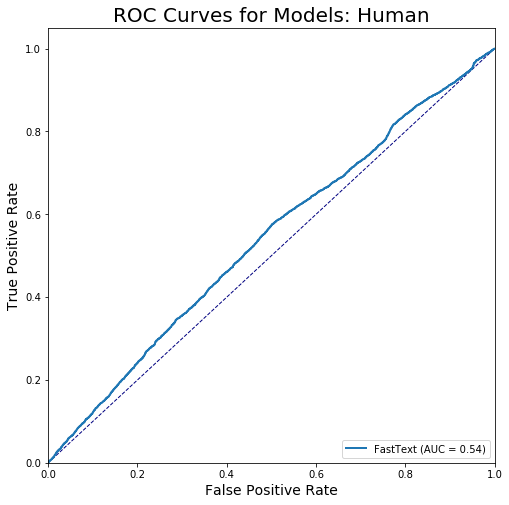

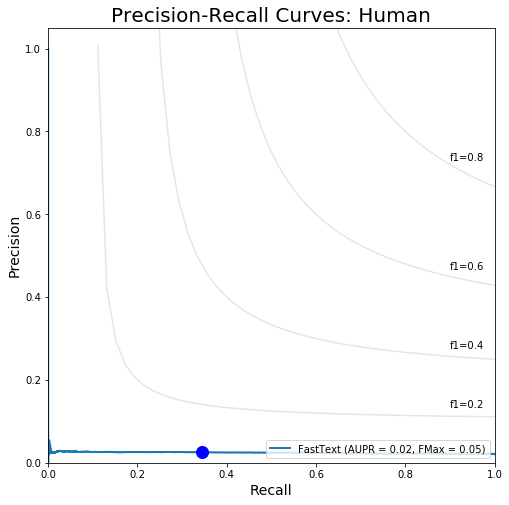

In [47]:
data_iter = batch_iter(batch_size, human_train_tensors, human_train_labels, human_train_lengths)

# Model Training
train_test(human_valid_tensors, human_valid_labels, human_valid_lengths, \
           num_epochs, optimizer, data_iter, model, data_size, method = 'GoTerm') 


test_set_predictions = model(Variable(human_test_tensors), Variable(human_test_lengths))
FScore, Threshold, Precision, Recall = F_score(test_set_predictions, human_test_labels) 

# Prediction on test set
print("Test Data F-Score for human protein prediction is", FScore, '\nPrecision:',Precision,
      '\nRecall:',Recall, '\nThreshold:', Threshold)

predictions = test_set_predictions.data.numpy()
actual = human_test_labels.numpy()
AUC = calculate_AUC(predictions, actual)[0]
AUPR = calculate_AUPR(predictions, actual)
print('AUC: %0.2f' % AUC)
print('AUPR: %0.2f' % AUPR)
plot_AUC_curve(predictions, actual, 'FastText', 'Human')
plot_AUPR_curve(predictions, actual, 'FastText', 'Human')

### Yeast Results

In [48]:
data_size = len(yeast_train_sequences) #3447
num_labels = yeast_GO_terms.shape[0] #26

model = FastText(vocab_size, emb_dim, num_labels)
criterion = nn.MultiLabelSoftMarginLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

/Users/danielamaranto/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


Epoch: [1/500], Step: [20/172], Train loss: 0.00531340840944024, 
F_Score: 0.24752185118193423, Threshold: 0.44, Precision: 0.14980583841618714, Recall: 0.7118514600427178, Validation Loss: 0.8746315240859985
Epoch: [1/500], Step: [40/172], Train loss: 0.005209065661873929, 
F_Score: 0.24284199898552153, Threshold: 0.31, Precision: 0.14066036476913804, Recall: 0.8877175433773469, Validation Loss: 0.8489096760749817
Epoch: [1/500], Step: [60/172], Train loss: 0.0051133986129317174, 
F_Score: 0.241065075519013, Threshold: 0.26, Precision: 0.14038385234116518, Recall: 0.8523779074444877, Validation Loss: 0.8267663717269897
earily stop triggered
Test Data F-Score for yeast protein prediction is 0.207437236265 
Precision: 0.155519124213 
Recall: 0.311391333349 
Threshold 0.44
AUC: 0.57
AUPR: 0.12


/Users/danielamaranto/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


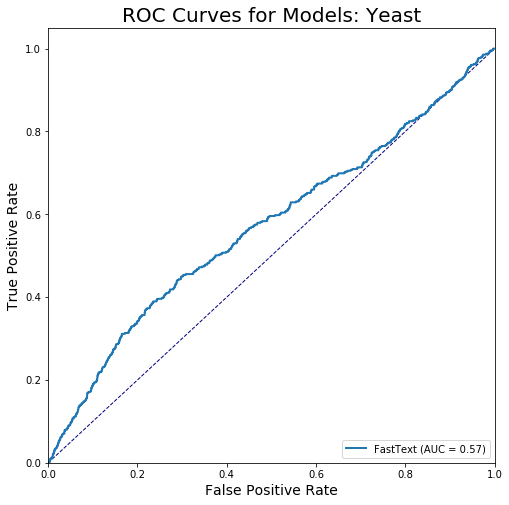

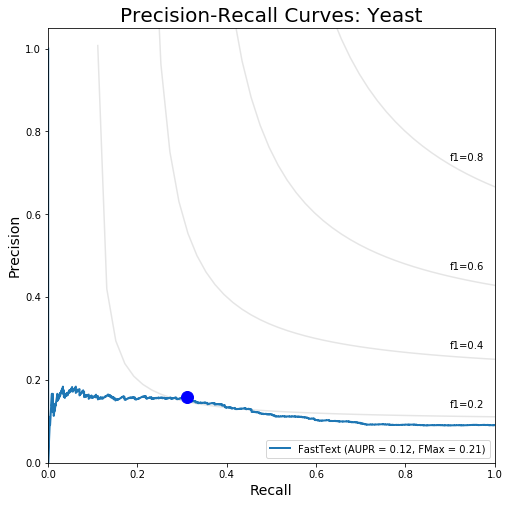

In [49]:
data_iter = batch_iter(batch_size, yeast_train_tensors, yeast_train_labels, yeast_train_lengths)

# Model Training
train_test(yeast_valid_tensors, yeast_valid_labels, yeast_valid_lengths, \
           num_epochs, optimizer, data_iter, model, data_size, method = 'GoTerm')

test_set_predictions = model(Variable(yeast_test_tensors), Variable(yeast_test_lengths))
FScore, Threshold, Precision, Recall = F_score(test_set_predictions, yeast_test_labels) 


# Prediction on test set
print("Test Data F-Score for yeast protein prediction is", FScore, '\nPrecision:',Precision,
      '\nRecall:',Recall, '\nThreshold', Threshold)

predictions = test_set_predictions.data.numpy()
actual = yeast_test_labels.numpy()
AUC = calculate_AUC(predictions, actual)[0]
AUPR = calculate_AUPR(predictions, actual)
print('AUC: %0.2f' % AUC)
print('AUPR: %0.2f' % AUPR)
plot_AUC_curve(predictions, actual, 'FastText', 'Yeast')
plot_AUPR_curve(predictions, actual, 'FastText', 'Yeast')